Standard SQuADv2 metric scores F1 for unanswerable questions as 1 if the prediction is correct else 0. Hence the mean F1 over unanswerable questions is just the accuracy. Note SQuAD does some text nromalisation first so a prediction with a non-empty string may become empty post-normalisation.

In [1]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score
from tqdm import tqdm

In [2]:
os.chdir('../..')

In [3]:
from src.analysis.utils import load_squadv2_dev_as_df
from src.analysis.generate_plot_data import generate_predictions_df

In [4]:
BATCH_SIZE = 32

Compute true F1 for unanswerable/answerable binary classification problem

In [5]:
# Load labels
labels_df = load_squadv2_dev_as_df()

# Load categories
categories = pd.read_csv(
    'data/processed/squadv2_dev_categories.csv',
    usecols=[
        'id', 'unanswerable'
    ]
)

seeds = [27, 29, 30]

f1_score_by_checkpoint_all_seeds = pd.DataFrame()

for seed in tqdm(seeds):
    
    model_filepath = f'predictions/albert-xlarge-v2-squadv2-wu=100-lr=3e5-bs=32-msl=384-seed={seed}'

    predictions_df = generate_predictions_df(model_filepath, seed)

    # Merge predictions and labels
    combined = predictions_df.merge(labels_df, on='id', how='inner')
    assert combined.shape[0] == predictions_df.shape[0]

    # Merge category columns
    combined = combined.merge(categories, on='id', how='inner')
    assert combined.shape[0] == predictions_df.shape[0]
    
    # Compute F1 score for binary classification problem
    combined["pred_unanswerable"] = np.where(
        combined['prediction_text'] == "",
        1,
        0
    )

    f1_score_by_checkpoint = combined.groupby('checkpoint').apply(
        lambda x: f1_score(x['unanswerable'], x['pred_unanswerable'])
    ).reset_index()
    
    f1_score_by_checkpoint.rename(columns={0: 'bin_f1'}, inplace=True)

    f1_score_by_checkpoint['num_examples'] = f1_score_by_checkpoint['checkpoint'] * BATCH_SIZE
    
    f1_score_by_checkpoint['seed'] = seed
    
    f1_score_by_checkpoint_all_seeds = f1_score_by_checkpoint_all_seeds.append(
        f1_score_by_checkpoint
    )

2021-07-24 23:37:15,902 - Loading SQuAD v2 dev data as DataFrame
2021-07-24 23:37:18,272 - Reusing dataset squad_v2 (/home/sgeorge/.cache/huggingface/datasets/squad_v2/squad_v2/2.0.0/de2e67b822b2ef3f4b137148d0758f48075e3892c359c50271ef6c9add7e794a)
2021-07-24 23:37:35,136 - (11873, 5)
2021-07-24 23:37:35,138 -                                              answers  \
0  {'text': ['France', 'France', 'France', 'Franc...   
1  {'text': ['10th and 11th centuries', 'in the 1...   
2  {'text': ['Denmark, Iceland and Norway', 'Denm...   
3  {'text': ['Rollo', 'Rollo', 'Rollo', 'Rollo'],...   
4  {'text': ['10th century', 'the first half of t...   

                                             context  \
0  The Normans (Norman: Nourmands; French: Norman...   
1  The Normans (Norman: Nourmands; French: Norman...   
2  The Normans (Norman: Nourmands; French: Norman...   
3  The Normans (Norman: Nourmands; French: Norman...   
4  The Normans (Norman: Nourmands; French: Norman...   

              

In [6]:
print(f1_score_by_checkpoint_all_seeds.shape)
f1_score_by_checkpoint_all_seeds.head()

(360, 4)


,checkpoint,bin_f1,num_examples,seed
0,1,0.0,32,27
1,2,0.0,64,27
2,3,0.0,96,27
3,4,0.0,128,27
4,5,0.0,160,27


Load HuggingFace metrics by answerable/unanswerable

In [7]:
metrics_by_cat = pd.DataFrame()

seeds = [27, 29, 30]
filepaths=[
    'data/processed/metrics_by_unanswerable-albert-xlarge-v2-squadv2-wu=100-lr=3e5-bs=32-msl=384-seed=27.csv',
    'data/processed/metrics_by_unanswerable-albert-xlarge-v2-squadv2-wu=100-lr=3e5-bs=32-msl=384-seed=29.csv',
    'data/processed/metrics_by_unanswerable-albert-xlarge-v2-squadv2-wu=100-lr=3e5-bs=32-msl=384-seed=30.csv'
]

for seed, fp in zip(seeds, filepaths):
    df = pd.read_csv(fp)
    df['seed'] = seed
    metrics_by_cat = metrics_by_cat.append(df)
    
metrics_by_cat['num_examples'] = metrics_by_cat['checkpoint'] * BATCH_SIZE

In [8]:
print(metrics_by_cat.shape)
metrics_by_cat.head()

(720, 19)


,exact,f1,total,HasAns_exact,HasAns_f1,HasAns_total,best_exact,best_exact_thresh,best_f1,best_f1_thresh,unanswerable,checkpoint,NoAns_exact,NoAns_f1,NoAns_total,overall_f1,overall_exact,seed,num_examples
0,0.067476,5.692667,5928,0.067476,5.692667,5928.0,0.067476,0.0,5.692667,0.0,0,1,NaN,NaN,NaN,2.88437,0.075802,27,32
1,0.084104,0.084104,5945,NaN,NaN,NaN,100.000000,0.0,100.000000,0.0,1,1,0.084104,0.084104,5945.0,2.88437,0.075802,27,32
2,0.067476,5.692667,5928,0.067476,5.692667,5928.0,0.067476,0.0,5.692667,0.0,0,2,NaN,NaN,NaN,2.88437,0.075802,27,64
3,0.084104,0.084104,5945,NaN,NaN,NaN,100.000000,0.0,100.000000,0.0,1,2,0.084104,0.084104,5945.0,2.88437,0.075802,27,64
4,0.067476,5.692667,5928,0.067476,5.692667,5928.0,0.067476,0.0,5.692667,0.0,0,3,NaN,NaN,NaN,2.88437,0.075802,27,96


Combine metrics DataFrames

In [9]:
f1_score_by_checkpoint_all_seeds['unanswerable'] = 1

In [10]:
metrics_by_cat = metrics_by_cat.merge(
    f1_score_by_checkpoint_all_seeds,
    on=['checkpoint', 'seed', 'num_examples', 'unanswerable'],
    how='left'
)

In [11]:
metrics_by_cat.head()

,exact,f1,total,HasAns_exact,HasAns_f1,HasAns_total,best_exact,best_exact_thresh,best_f1,best_f1_thresh,unanswerable,checkpoint,NoAns_exact,NoAns_f1,NoAns_total,overall_f1,overall_exact,seed,num_examples,bin_f1
0,0.067476,5.692667,5928,0.067476,5.692667,5928.0,0.067476,0.0,5.692667,0.0,0,1,NaN,NaN,NaN,2.88437,0.075802,27,32,NaN
1,0.084104,0.084104,5945,NaN,NaN,NaN,100.000000,0.0,100.000000,0.0,1,1,0.084104,0.084104,5945.0,2.88437,0.075802,27,32,0.0
2,0.067476,5.692667,5928,0.067476,5.692667,5928.0,0.067476,0.0,5.692667,0.0,0,2,NaN,NaN,NaN,2.88437,0.075802,27,64,NaN
3,0.084104,0.084104,5945,NaN,NaN,NaN,100.000000,0.0,100.000000,0.0,1,2,0.084104,0.084104,5945.0,2.88437,0.075802,27,64,0.0
4,0.067476,5.692667,5928,0.067476,5.692667,5928.0,0.067476,0.0,5.692667,0.0,0,3,NaN,NaN,NaN,2.88437,0.075802,27,96,NaN


## Plots

### Full checkpoints

In [12]:
metrics_by_cat['f1_true_comparison'] = np.where(
    metrics_by_cat['unanswerable'] == 1,
    metrics_by_cat['bin_f1'] * 100,
    metrics_by_cat['f1']
)

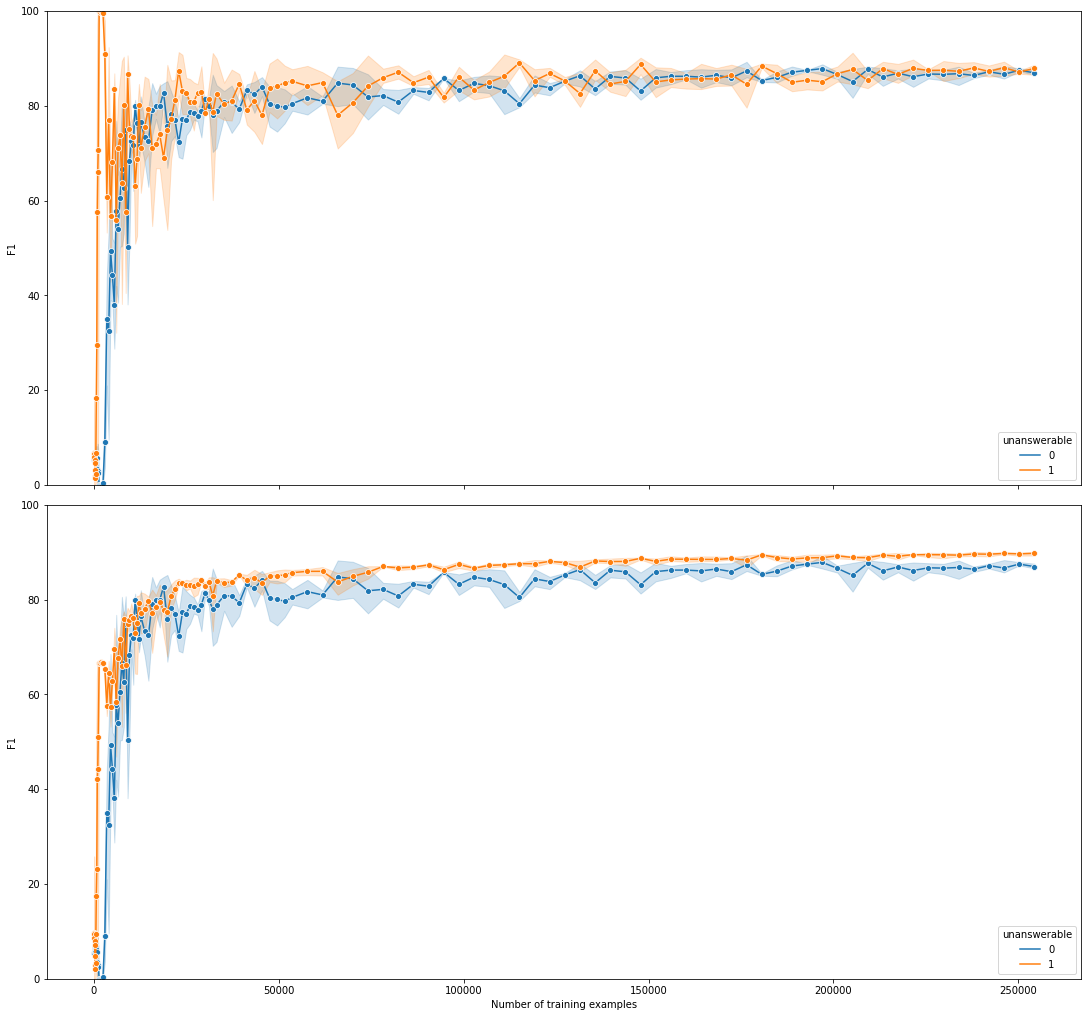

In [14]:
fig = plt.figure(constrained_layout=True, figsize=(15, 14))
gs = fig.add_gridspec(2, 1)

# Overall (all examples) by seed
ax2 = fig.add_subplot(gs[1, :])
ax2.set_xlabel('Number of training examples')
ax2.set_ylabel('F1')
ax2.set_ylim(0, 100)
sns.lineplot(data=metrics_by_cat, y='f1_true_comparison', x='num_examples', hue='unanswerable', marker='o', palette='tab10', ax=ax2)
ax2.legend(title='unanswerable', loc='lower right')

# By category
ax1 = fig.add_subplot(gs[0, :], sharex=ax2, sharey=ax2)
plt.setp(ax1.get_xticklabels(), visible=False)
ax1.set_ylabel('F1')
ax1.set_ylim(0, 100)
sns.lineplot(data=metrics_by_cat, y='f1', x='num_examples', hue='unanswerable', marker='o', palette='tab10', ax=ax1)
ax1.legend(title='unanswerable', loc='lower right')

plt.savefig('reports/figures/squadv2-UnansAns-AllCheckpoints.pdf')

plt.show()

### <15k

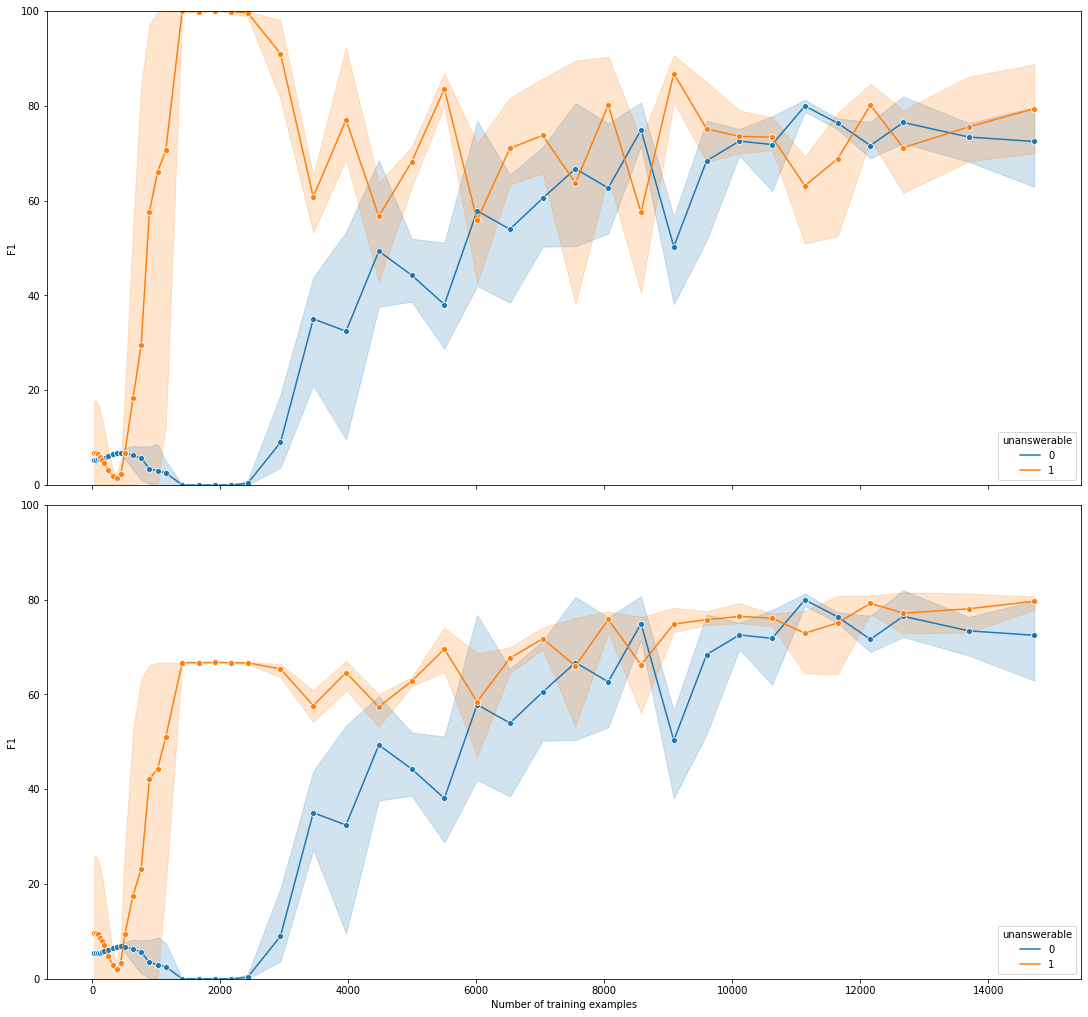

In [18]:
example_cutoff = 15000


fig = plt.figure(constrained_layout=True, figsize=(15, 14))
gs = fig.add_gridspec(2, 1)

# Overall (all examples) by seed
ax2 = fig.add_subplot(gs[1, :])
ax2.set_xlabel('Number of training examples')
ax2.set_ylabel('F1')
ax2.set_ylim(0, 100)
sns.lineplot(data=metrics_by_cat[metrics_by_cat['num_examples'] < example_cutoff], y='f1_true_comparison', x='num_examples', hue='unanswerable', marker='o', palette='tab10', ax=ax2)
ax2.legend(title='unanswerable', loc='lower right')

# By category
ax1 = fig.add_subplot(gs[0, :], sharex=ax2, sharey=ax2)
plt.setp(ax1.get_xticklabels(), visible=False)
ax1.set_ylabel('F1')
ax1.set_ylim(0, 100)
sns.lineplot(data=metrics_by_cat[metrics_by_cat['num_examples'] < example_cutoff], y='f1', x='num_examples', hue='unanswerable', marker='o', palette='tab10', ax=ax1)
ax1.legend(title='unanswerable', loc='lower right')

plt.savefig('reports/figures/squadv2-UnansAns-15k.pdf')

plt.show()

### Unanswerable true F1 by seed

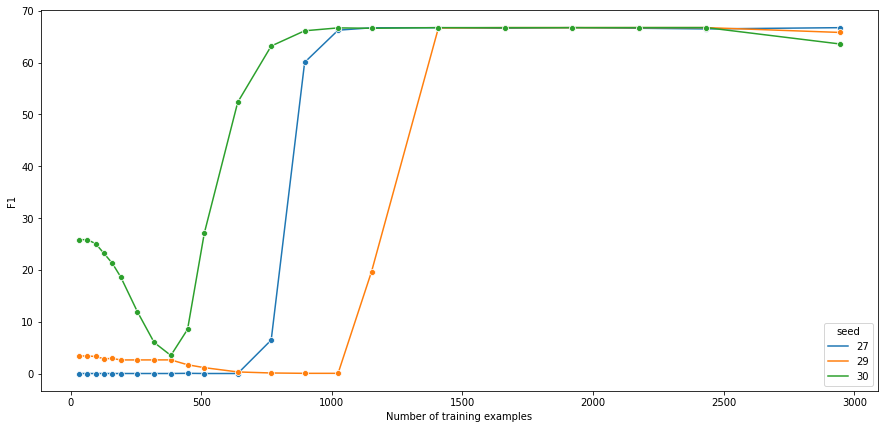

In [34]:
plt.figure(figsize=(15, 7))
sns.lineplot(
    data=metrics_by_cat[
        (metrics_by_cat['num_examples'] < 3000) &
        (metrics_by_cat['unanswerable'] == 1)
    ], 
    y='f1_true_comparison', 
    x='num_examples', 
    hue='seed', 
    marker='o', 
    palette='tab10'
)
plt.ylabel('F1')
plt.legend(title='seed', loc='lower right')
plt.xlabel('Number of training examples')
plt.savefig('reports/figures/squadv2-Unans-3k-BySeed.pdf')
plt.show()

## Other metrics to report

### Proportion of examples predicted as unanswerable in regions where HF F1 is 100

In [17]:
metrics_by_cat[(metrics_by_cat['unanswerable'] == 1) & (metrics_by_cat['f1'] == 100)].head()

,exact,f1,total,HasAns_exact,HasAns_f1,HasAns_total,best_exact,best_exact_thresh,best_f1,best_f1_thresh,unanswerable,checkpoint,NoAns_exact,NoAns_f1,NoAns_total,overall_f1,overall_exact,seed,num_examples,bin_f1
37,100.0,100.0,5945,NaN,NaN,NaN,100.0,0.0,100.0,0.0,1,60,100.0,100.0,5945.0,50.071591,50.071591,27,1920,0.667303
275,100.0,100.0,5945,NaN,NaN,NaN,100.0,0.0,100.0,0.0,1,52,100.0,100.0,5945.0,50.071591,50.071591,29,1664,0.667303
277,100.0,100.0,5945,NaN,NaN,NaN,100.0,0.0,100.0,0.0,1,60,100.0,100.0,5945.0,50.071591,50.071591,29,1920,0.667303
279,100.0,100.0,5945,NaN,NaN,NaN,100.0,0.0,100.0,0.0,1,68,100.0,100.0,5945.0,50.071591,50.071591,29,2176,0.667303
281,100.0,100.0,5945,NaN,NaN,NaN,100.0,0.0,100.0,0.0,1,76,100.0,100.0,5945.0,50.080013,50.080013,29,2432,0.667340


In [23]:
temp_df = metrics_by_cat[(metrics_by_cat['unanswerable'] == 1)].groupby(['checkpoint', 'num_examples']).mean().reset_index()
temp_df.head()

,checkpoint,num_examples,exact,f1,total,HasAns_exact,HasAns_f1,HasAns_total,best_exact,best_exact_thresh,best_f1,best_f1_thresh,unanswerable,NoAns_exact,NoAns_f1,NoAns_total,overall_f1,overall_exact,seed,bin_f1
0,1,32,6.767592,6.767592,5945.0,NaN,NaN,NaN,100.0,0.0,100.0,0.0,1.0,6.767592,6.767592,5945.0,6.058262,3.433561,28.666667,0.097346
1,2,64,6.767592,6.767592,5945.0,NaN,NaN,NaN,100.0,0.0,100.0,0.0,1.0,6.767592,6.767592,5945.0,6.058262,3.433561,28.666667,0.097346
2,3,96,6.526493,6.526493,5945.0,NaN,NaN,NaN,100.0,0.0,100.0,0.0,1.0,6.526493,6.526493,5945.0,5.965477,3.312839,28.666667,0.094493
3,4,128,5.881693,5.881693,5945.0,NaN,NaN,NaN,100.0,0.0,100.0,0.0,1.0,5.881693,5.881693,5945.0,5.685561,2.989977,28.666667,0.086730
4,5,160,5.365854,5.365854,5945.0,NaN,NaN,NaN,100.0,0.0,100.0,0.0,1.0,5.365854,5.365854,5945.0,5.492754,2.728881,28.666667,0.080555


In [28]:
temp_df[(temp_df['checkpoint'] >= 36) & (temp_df['checkpoint'] <= 92)]

,checkpoint,num_examples,exact,f1,total,HasAns_exact,HasAns_f1,HasAns_total,best_exact,best_exact_thresh,best_f1,best_f1_thresh,unanswerable,NoAns_exact,NoAns_f1,NoAns_total,overall_f1,overall_exact,seed,bin_f1
15,36,1152,70.580320,70.580320,5945.0,NaN,NaN,NaN,100.0,0.0,100.0,0.0,1.0,70.580320,70.580320,5945.0,36.619916,35.545636,28.666667,0.509852
16,44,1408,99.927110,99.927110,5945.0,NaN,NaN,NaN,100.0,0.0,100.0,0.0,1.0,99.927110,99.927110,5945.0,50.036297,50.035094,28.666667,0.667091
17,52,1664,99.871040,99.871040,5945.0,NaN,NaN,NaN,100.0,0.0,100.0,0.0,1.0,99.871040,99.871040,5945.0,50.007477,50.007019,28.666667,0.666903
18,60,1920,100.000000,100.000000,5945.0,NaN,NaN,NaN,100.0,0.0,100.0,0.0,1.0,100.000000,100.000000,5945.0,50.071591,50.071591,28.666667,0.667303
19,68,2176,99.848612,99.848612,5945.0,NaN,NaN,NaN,100.0,0.0,100.0,0.0,1.0,99.848612,99.848612,5945.0,50.004039,49.998596,28.666667,0.666941
20,76,2432,99.590692,99.590692,5945.0,NaN,NaN,NaN,100.0,0.0,100.0,0.0,1.0,99.590692,99.590692,5945.0,50.037595,50.015441,28.666667,0.666525
21,92,2944,90.984020,90.984020,5945.0,NaN,NaN,NaN,100.0,0.0,100.0,0.0,1.0,90.984020,90.984020,5945.0,50.038289,49.307954,28.666667,0.653699


In [49]:
all_predictions = pd.DataFrame()

for seed in tqdm(seeds):
    
    model_filepath = f'predictions/albert-xlarge-v2-squadv2-wu=100-lr=3e5-bs=32-msl=384-seed={seed}'

    predictions_df = generate_predictions_df(model_filepath, seed)
    
    predictions_df["pred_unanswerable"] = np.where(
        predictions_df['prediction_text'] == "",
        1,
        0
    )
    
    predictions_df['seed'] = seed
    
    all_predictions = all_predictions.append(predictions_df, ignore_index=True)

100%|██████████| 3/3 [00:26<00:00,  8.85s/it]


In [54]:
all_predictions[(all_predictions['checkpoint'] >= 44) & (all_predictions['checkpoint'] <= 76)].groupby('seed')['pred_unanswerable'].mean()

seed
27    0.995822
29    0.999613
30    0.999798
Name: pred_unanswerable, dtype: float64